[View in Colaboratory](https://colab.research.google.com/github/christopher-ell/Deep_Learning_Begin/blob/master/OPT_TransferLearning_AntBees.ipynb)

Official Pytorch Tutorials - Transfer Learning

Source: http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [3]:
## File created in Google colaboratory so need to download libraries and data on begin 
!pip install torch
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
    100% |████████████████████████████████| 484.0MB 21kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x55e9227ae000 @  0x7f108b1e61c4 0x55e8c5ffe0d8 0x55e8c60e7d5d 0x55e8c601177a 0x55e8c6016462 0x55e8c600eb3a 0x55e8c601682e 0x55e8c600eb3a 0x55e8c601682e 0x55e8c600eb3a 0x55e8c601682e 0x55e8c600eb3a 0x55e8c6016e1f 0x55e8c600eb3a 0x55e8c601682e 0x55e8c600eb3a 0x55e8c601682e 0x55e8c6016462 0x55e8c6016462 0x55e8c600eb3a 0x55e8c6016e1f 0x55e8c6016462 0x55e8c600eb3a 0x55e8c6016e1f 0x55e8c600eb3a 0x55e8c6016e1f 0x55e8c600eb3a 0x55e8c601682e 0x55e8c600eb3a 0x55e8c603f50f 0x55e8c603a202
Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
    100% |████████████████████████████████| 61kB 2.3MB/s 
    40% |█████████████                   | 798kB 6.9MB/s eta 0:00:01

    100% |████████████████████████████████| 2.0MB 7.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [4]:
## File created in Google colaboratory so need to download libraries and data on begin 
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2018-04-29 09:05:22--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.239.172.114, 54.239.172.175, 54.239.172.189, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.239.172.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  26.7MB/s    in 1.7s    

2018-04-29 09:05:24 (26.7 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera


  inflating: hymenoptera_data/val/bees/1297972485_33266a18d9.jpg  
  inflating: hymenoptera_data/val/bees/1328423762_f7a88a8451.jpg  
  inflating: hymenoptera_data/val/bees/1355974687_1341c1face.jpg  
  inflating: hymenoptera_data/val/bees/144098310_a4176fd54d.jpg  
  inflating: hymenoptera_data/val/bees/1486120850_490388f84b.jpg  
  inflating: hymenoptera_data/val/bees/149973093_da3c446268.jpg  
  inflating: hymenoptera_data/val/bees/151594775_ee7dc17b60.jpg  
  inflating: hymenoptera_data/val/bees/151603988_2c6f7d14c7.jpg  
  inflating: hymenoptera_data/val/bees/1519368889_4270261ee3.jpg  
  inflating: hymenoptera_data/val/bees/152789693_220b003452.jpg  
  inflating: hymenoptera_data/val/bees/177677657_a38c97e572.jpg  
  inflating: hymenoptera_data/val/bees/1799729694_0c40101071.jpg  
  inflating: hymenoptera_data/val/bees/181171681_c5a1a82ded.jpg  
  inflating: hymenoptera_data/val/bees/187130242_4593a4c610.jpg  
  inflating: hymenoptera_data/val/bees/203868383_0fcbb48278.jpg  
  i

Two Major Transfer Learning Scenarios

1) Finetuning The Covnet: Instead of randomised initiation, the network is initialised with a pretrained network, like the one trained on imagenet 1000 dataset. 

2) ConvNet as Fixed Feature Extractor: Freeze the weights for the whole network except the final fully connected layer. The final layer is replaced by one with random weights and is the only layer trained

**1. Dependencies**

In [0]:
# Dependencies
import time
import os
import copy
import matplotlib.pyplot as plt
from __future__ import print_function, division
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

plt.ion() # interactive mode

**2. Load Data**

In [0]:
# Data auguementation and normalisation for training
# Just normalisation for validation

## Tansforms are stored in a dictionary 
## Transforms have a number of purposes here, including to:
##    i) Make the images compatible with Pytorch i.e. ToTensor()
##    ii) Allow the images to be run more efficiently i.e. Normalise()
##    iii) Make image size compatible with NN by making all images the same size
##         i.e. RandomResizedCrop(224)
##    iv) Prevent overfitting / create new data by randomly making change to the 
##        while keeping it's subject the same i.e. RandomHorizontalFlip()
## Compose groups a set of transforms together
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
## For validation some of the above transforms are unnecessary. transforms which
## put the image in Pytorch format, normalise it and make images the same size 
## are still important. But randomisaton is gone in the resize and crop and image
## flip is gone because you do not require more data
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

## Name of dataset beng used
data_dir = 'hymenoptera_data'
## import the training and validation set of images by looping through both entries
## in the dictionary. 
## Create a new dictionary of the datasets and transforms for each set of training
## and validation images
## use ImageFolder from the datasets library to import a foler of images in each
## of the categories
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x), 
                                        data_transforms[x])
                 for x in ['train', 'val']}

## Create dictionary of training and validation dataloaders by looping through 
## the image datasets dictionary. 
## Apply batch_size of 4, meaning in each training loop 4 images at a time will
## be run through the loop
## Shuffle: reshuffles data at every epoch
## num_workers: Number of subprocesses running at a time.
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                            shuffle=True, num_workers=4)
              for x in ['train', 'val']}

## Create dictionary storing the size of each training and validation set
dataset_sizes = {x:len(image_datasets[x]) for x in ['train', 'val']}

## Create list of class names to look up when visualising results.
class_names = image_datasets['train'].classes

## Create function that returns "cuda:0" if it is being run with a GPU and cpu
## if it is not being run on a GPU but instead a CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
print(class_names)

['ants', 'bees']


**3. Visualise a Few Images**

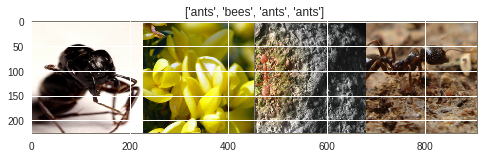

In [4]:
def imshow(inp, title=None):
  """imshow for Tensor."""
  ## inp.numpy converts the image (inp) into a numpy array
  ## transpose changes the dimensions of the array so all images have same 
  ## dimensions
  inp = inp.numpy().transpose((1, 2, 0))
  ## Set mean and standard deviation of images, so they are consistent
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  ## Sets the maximum value in each array
  inp = np.clip(inp, 0, 1)
  ## Show the image
  plt.imshow(inp)
  ## Show the title of the images if it exists
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so plots are updated
  
  
# Get a batch of training data
## next() retrieves the next item in the iterator
## iter() without a second object must be a collection object 
## Takes one batch of pictures and labels (0 or 1)
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
## torchvision.utils.make_grid() creates a grid of images from the tensor inputs
out = torchvision.utils.make_grid(inputs)

## Run above function to standardise and show all images in batch
imshow(out, title=[class_names[x] for x in classes])

**4. Training The Model**

In [0]:
def train_model(model, criterion, optimiser, scheduler, num_epochs=25):  
  ## Record time that training starts
  since = time.time()
  
  ## Set initial best model version to provided model
  best_model_wts = copy.deepcopy(model.state_dict())
  ## Set best accuracy to 0
  best_acc = 0.0
  
  ## Output current epoch of total epochs and ten dashes underneath
  for epoch in range(num_epochs):
    ## Current epoch over total epochs
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    ## Ten dashes
    print('-'*10)
    
    # Each epoch has a training and validation phase
    ## Loop through first a training phase than a validation phase
    for phase in ['train', 'val']:
      ## If the program is in the training phase
      if phase == 'train':
        ## Sets up how the learning rate will be adjusted over time
        scheduler.step()
        ## Puts the model in training mode
        model.train() # Set model to training mode 
      else:
        ## Puts the model into evaluation mode
        model.eval() # Set model to evaluation mode
        
      ## Initialise values of running_loss and running_corrects
      running_loss = 0.0
      running_corrects = 0
      
      # Iterate over data
      ## Iterate of training/validation data batches
      for inputs, labels in dataloaders[phase]:
        ## Set the image type and label to cuda:10 or CPU processing 
        ## based on whether or not the computer has a GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        ## zero gradients as they are cumulative
        optimiser.zero_grad()
        
        # forward
        # track history if only in train
        ## If you are training the model do the below
        with torch.set_grad_enabled(phase == 'train'):
          ## Run the model to get outputs
          outputs = model(inputs)
          ## Take the max output for each example as the prediction
          _, preds = torch.max(outputs, 1)
          ## Run the predictions against the actual results with the loss 
          ## function to get the loss
          loss = criterion(outputs, labels)
          
          # backwards + optimise only if in training phase
          ## If program is in training phase run backpropagation and 
          ## update weights using specified update algorithm
          if phase == 'train':
            loss.backward()
            optimiser.step()
          
        # Statistics
        ## Loss.item() gives loss fo each batch and input.size(0) gives number of
        ## items for each batch. So it is total loss for every image/input
        running_loss += loss.item() * inputs.size(0)
        #print("loss.item(): ", loss.item(), " inputs.size(0): ", inputs.size(0))
        ## Adds all instances where the predicted label was equal to the label
        running_corrects += torch.sum(preds==labels.data)
      
      
      ## Running_loss is total loss from epoch and dataset_size is size of total
      ## dataset in epoch. So this gives average loss per input in epoch
      epoch_loss = running_loss / dataset_sizes[phase]
      #print("running_loss: ", running_loss, " dataset_sizes[phase]: ", dataset_sizes[phase])
      ## running_corrects.double()  gives total number of correct answers as a double type
      ## dataset_sizes[phase] gives total size of dataset
      ## epoch_acc gives otal accuracy of predictions in epoch (correct/total)
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      
      ## Outputs in formatted way whether validation ot training result, the loss
      ## per input in epoch and the accuracy in the epoch
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))
      
      # Deep copy the model
      ## If the accuracy (validation) of the current model is better than the 
      ## accuracy (validation) of the best model so far copy the current model 
      ## into the best model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
    print()
    
  ## Calculate how long since the model started running  
  time_elapsed = time.time() - since
  ## Print out how long since the model started running by minutes and seconds
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  ## Print best models accuracy
  print('Best val Acc: {:4f}'.format(best_acc)) 
  
  # Load best model weights
  model.load_state_dict(best_model_wts)
  return model

**5. Visualising The Model Predictions**

In [0]:
def visualise_model(model, num_images=6):
  ## Function to put model into training mode
  was_training=model.training
  ## Put model into evaluation mode
  model.eval()
  ## Initialise image_sso_far to 0
  images_so_far = 0
  ## Plot figures
  fig = plt.figure()
  
  ## ???? ##
  with torch.no_grad():
    ## Iterate through each batch of the dataloader 
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      ## Wrap inputs and labels in relevant type depending on whether the 
      ## computer des or does not have a GPU
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      ## Run the model and get the results as outputs
      outputs = model(inputs)
      ## Take the maximum prediction value in each example as the prediction
      _, preds = torch.max(outputs, 1)
      
      ## Iterate through each example in the validation set
      for j in range(inputs.size()[0]):
        ## Every time you go through an additional example add 1 to counter
        images_so_far += 1
        ## Returns a subplot of the image with the dimensions  
        ##    rows = num_images//2  columns = 2
        ## image is image_so_far
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ## Switch off axis
        ax.axis('off')
        ## Title is the value predicted by the model
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        ## Show the image
        imshow(inputs.cpu().data[j])
        
        ## When the program gets to the end of all images set the model back to 
        ##training mode
        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

**6. Finetuning The CovNet**

  - Load pretrained model and retrain final layer on the ants and bees data

In [7]:
## Use preexisting trained model Resnet 18
model_ft = models.resnet18(pretrained=True)
## in_features gives the size of each input sample
## Hence num_ftrs gives the number of features in the final layer of the model
## Here it is 512
num_ftrs = model_ft.fc.in_features
## Set final layer to a linear transform with two out features one giving 
## probability of ant and the other probability of bee
model_ft.fc = nn.Linear(num_ftrs, 2)

## Set the way the model fits based on whether it is operating on a GPU
model_ft = model_ft.to(device)

## The loss function will be a CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being rferenced
## Calculate the weights of the model using Stochastic Gradient Descent
##   lr is learning rate, which adjust how much the weights change each iteration
##   momentum is a method which helps accelerate SGD in the rght direction
##   momentum creates a moving average gradient rather than just a gradient
##   making the convergence to values faster
optimiser_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
## This reduces the value of the learning rate over time so that as the weights
## get closer to the optimal ones the learning rate becomes smaller meaning
## there are smaller changes to the weights
exp_lr_scheduler = lr_scheduler.StepLR(optimiser_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /content/.torch/models/resnet18-5c106cde.pth
13.9%

100.0%


**7. Train and Evaluate**

In [8]:
## Train the model Using above specified loss function (criterion), optimiser function (SGD with momentum) and learning rate that decays
## 25 epochs means the model will run through the dataset 25 times
model_ft = train_model(model_ft, criterion, optimiser_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6265 Acc: 0.6967
val Loss: 0.2333 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.5451 Acc: 0.7541
val Loss: 0.2871 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.6493 Acc: 0.7418
val Loss: 0.1828 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.5324 Acc: 0.7910
val Loss: 0.6629 Acc: 0.8039

Epoch 4/24
----------
train Loss: 0.5140 Acc: 0.7869
val Loss: 0.3695 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.5783 Acc: 0.7746
val Loss: 0.4894 Acc: 0.7843

Epoch 6/24
----------
train Loss: 0.4622 Acc: 0.8156
val Loss: 0.3428 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.2564 Acc: 0.8811
val Loss: 0.2706 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.4276 Acc: 0.8361
val Loss: 0.2625 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.2993 Acc: 0.8689
val Loss: 0.2625 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2163 Acc: 0.9303
val Loss: 0.2638 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2265 Acc: 0.8975
val Loss: 0.2420 Acc: 0.9216

Ep

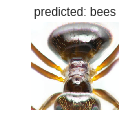

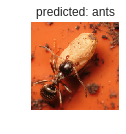

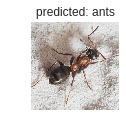

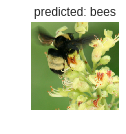

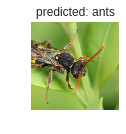

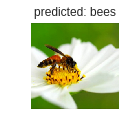

Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f6dc0faa510>> ignored


In [9]:
## Output 6 images from the validation set with the prediction above as a title
visualise_model(model_ft)

**8. CovNet as Fixed Feature Extractor**
   - Freeze whole network except final layer.

In [0]:
## Download and set the pretrained Resnet18 model to the model we will use
model_conv = torchvision.models.resnet18(pretrained=True)

## Iterate through each parameter in the model
for param in model_conv.parameters():
  ## Each tensor has the flag requires_grad, setting it to false allows freezes
  ## the parmaeter associated with it
  param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
## Create new modules that will become final layer
num_ftrs = model_conv.fc.in_features
## Give final layers a linear transform with two outputs one for each category
model_conv.fc = nn.Linear(num_ftrs, 2)

## Create new model and tell it whether the computer has a GPU or not
model_conv = model_conv.to(device)

## Specify loss function to be CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimised as
# opposed to before.
## This time when running SGD only the final layer is being optimised with 
## fc ??
optimiser_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
## Set decay rate so as the weights of parameters get closer to optimal values
## the learning rate goes down so the program takes smaller steps
exp_lr_scheduler = lr_scheduler.StepLR(optimiser_conv, step_size=7, gamma=0.1)

**9. Train and Evaluate**

In [11]:
## Run training of final layer of model 
model_conv = train_model(model_conv, criterion, optimiser_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6030 Acc: 0.6803
val Loss: 0.2601 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4970 Acc: 0.7746
val Loss: 0.2040 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.5020 Acc: 0.7664
val Loss: 0.3398 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.4569 Acc: 0.7910
val Loss: 0.1884 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.3875 Acc: 0.8402
val Loss: 0.1829 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5976 Acc: 0.7418
val Loss: 0.1761 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.5645 Acc: 0.7459
val Loss: 0.2748 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.4250 Acc: 0.8115
val Loss: 0.1973 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3182 Acc: 0.8689
val Loss: 0.1816 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3302 Acc: 0.8443
val Loss: 0.1817 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3489 Acc: 0.8566
val Loss: 0.2013 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3709 Acc: 0.8443
val Loss: 0.1940 Acc: 0.9477

Ep

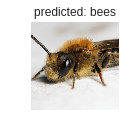

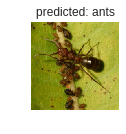

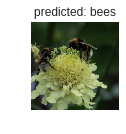

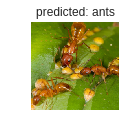

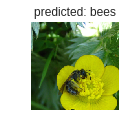

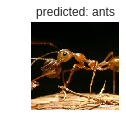

Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f6d8c7b3350>> ignored


In [12]:
visualise_model(model_conv)

## ioff turns interactive mode on the graph off
plt.ioff()
## Displays the figure
plt.show()